In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Define paths to your datasets and labels
datasets_and_labels = [
    {
        "dataset_path": "C:/Users/USER/Desktop/gp2 ct scan/our all cases/CASES",
        "labels_path": "C:/Users/USER/Desktop/gp2 ct scan/GP2/CSV_DATASETS/cleaned_dataset_CASES.csv"
    },
    {
        "dataset_path": "C:/Users/USER/Desktop/gp2 ct scan/our all cases/extra cases",
        "labels_path": "C:/Users/USER/Desktop/gp2 ct scan/GP2/GP2 notebooks/14-5/CSV/ZEROS EXTRA.csv"
    },
    {
        "dataset_path": "C:/Users/USER/Desktop/gp2 ct scan/our all cases/extra cases 2",
        "labels_path": "C:/Users/USER/Desktop/gp2 ct scan/GP2/GP2 notebooks/14-5/CSV/ZEROS EXTRA 2.csv"
    }
]

# Initialize a dictionary to hold images for each patient
patient_images = defaultdict(list)
patient_labels = {}

# Function to check if the file is an image
def is_image_file(filename):
    return filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))

# Load and preprocess images for each dataset and corresponding labels
for entry in datasets_and_labels:
    dataset = entry["dataset_path"]
    labels_path = entry["labels_path"]

    # Load labels data
    labels_data = pd.read_csv(labels_path)

    for folder in os.listdir(dataset):
        folder_path = os.path.join(dataset, folder)
        if os.path.isdir(folder_path):
            case_id = folder.split('-')[0]
            images_path = os.path.join(folder_path, "Images") if "Images" in os.listdir(folder_path) else folder_path
            
            if case_id in labels_data['id'].values:
                surgery_label = labels_data[labels_data['id'] == case_id]['surgery'].values[0]
                patient_labels[case_id] = surgery_label
                if os.path.isdir(images_path):
                    all_images = [f for f in os.listdir(images_path) if is_image_file(f)]
                    valid_images = all_images[25:-10]  # Skip first 25 images and last 10 images
                    
                    for filename in valid_images:
                        file_path = os.path.join(images_path, filename)
                        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            img = cv2.resize(img, (224, 224))
                            img = np.stack((img,)*3, axis=-1)  # Convert grayscale to RGB
                            patient_images[case_id].append(img)
                        else:
                            print(f"Failed to load image: {file_path}")

print("Loaded images for all datasets.")


Loaded images for all datasets.


In [2]:
len(patient_images)

239

In [7]:

import numpy as np
from sklearn.model_selection import train_test_split


# Split patients into train and test sets
patient_ids = list(patient_images.keys())

np.random.shuffle(patient_ids) # shuffle before split train test 
train_ids, test_ids = train_test_split(patient_ids, test_size=0.15, random_state=42)

# Extend images for each subset
train_images = []
train_labels = []
for id in train_ids:
    train_images.extend(patient_images[id])
    train_labels.extend([patient_labels[id]] * len(patient_images[id]))

test_images = []
test_labels = []
for id in test_ids:
    test_images.extend(patient_images[id])
    test_labels.extend([patient_labels[id]] * len(patient_images[id]))

# Proceed with the rest of your model setup and training

# Convert lists to numpy arrays
X_train, y_train = np.array(train_images), np.array(train_labels)
X_test, y_test = np.array(test_images), np.array(test_labels)
import numpy as np



# Count occurrences of each label in the training set
unique, counts_train = np.unique(y_train, return_counts=True)
train_label_counts = dict(zip(unique, counts_train))
print("Label counts in training data:", train_label_counts)

# Count occurrences of each label in the test set
unique, counts_test = np.unique(y_test, return_counts=True)
test_label_counts = dict(zip(unique, counts_test))
print("Label counts in test data:", test_label_counts)

Label counts in training data: {0: 5645, 1: 7832}
Label counts in test data: {0: 828, 1: 1859}


C:\Users\USER\AppData\Local\Temp\ipykernel_14988\685834253.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(train_label_counts)).colors


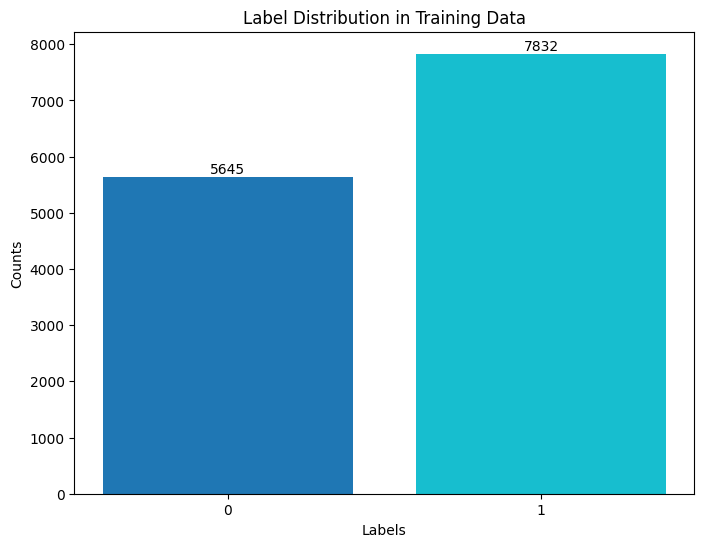

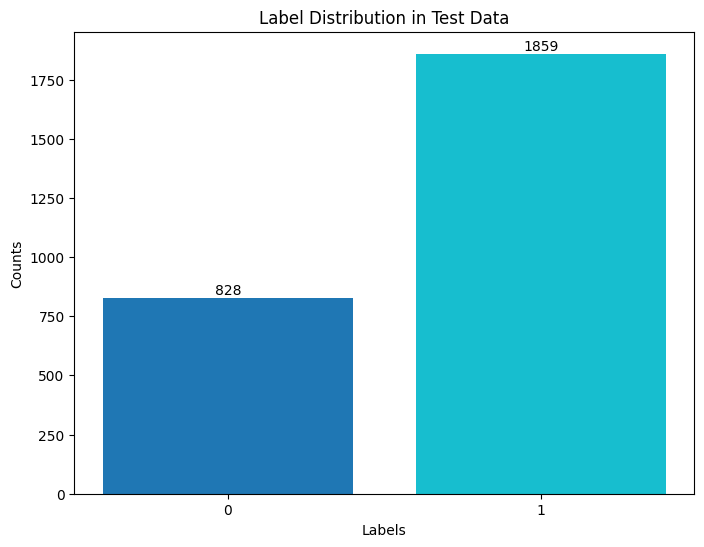

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a list of different colors
colors = plt.cm.get_cmap('tab10', len(train_label_counts)).colors

# Visualize the distribution of labels in the training set
def plot_label_distribution(label_counts, title, colors):
    labels = list(label_counts.keys())
    counts = list(label_counts.values())
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, counts, color=colors[:len(labels)])
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(title)
    plt.xticks(labels)
    
    # Add counts on top of bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, int(count), ha='center', va='bottom')
    
    plt.show()

# Plot label distribution for training data
plot_label_distribution(train_label_counts, 'Label Distribution in Training Data', colors)

# Plot label distribution for test data
plot_label_distribution(test_label_counts, 'Label Distribution in Test Data', colors)


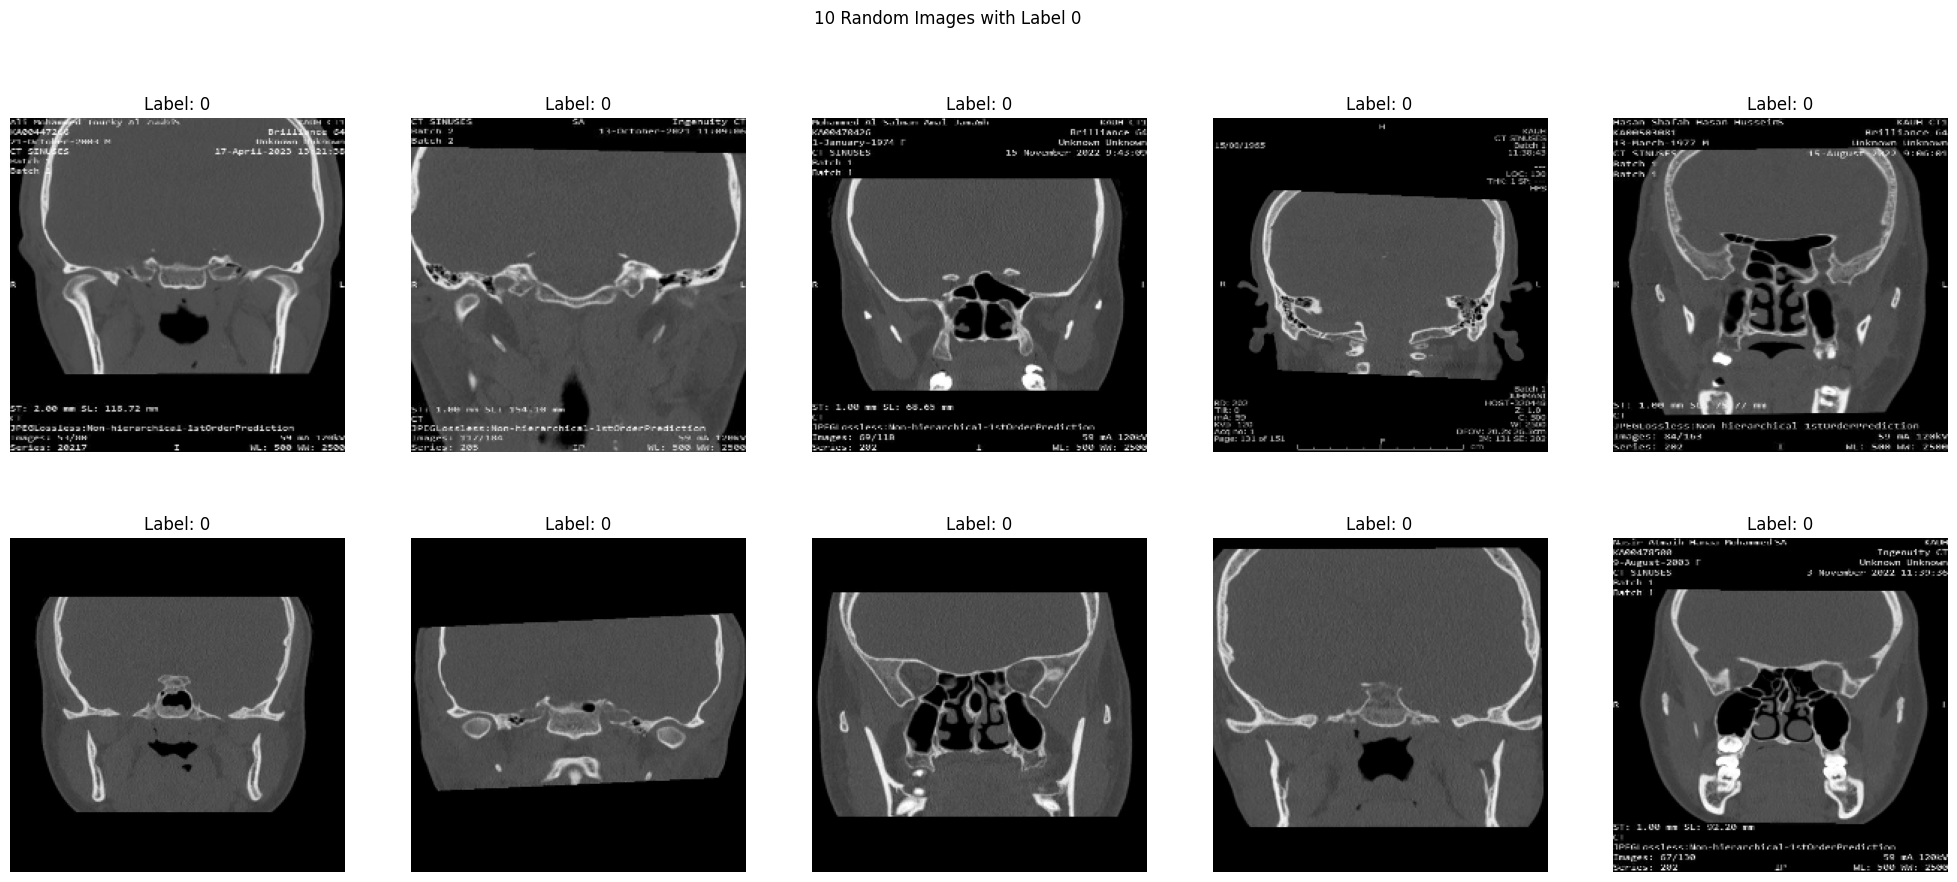

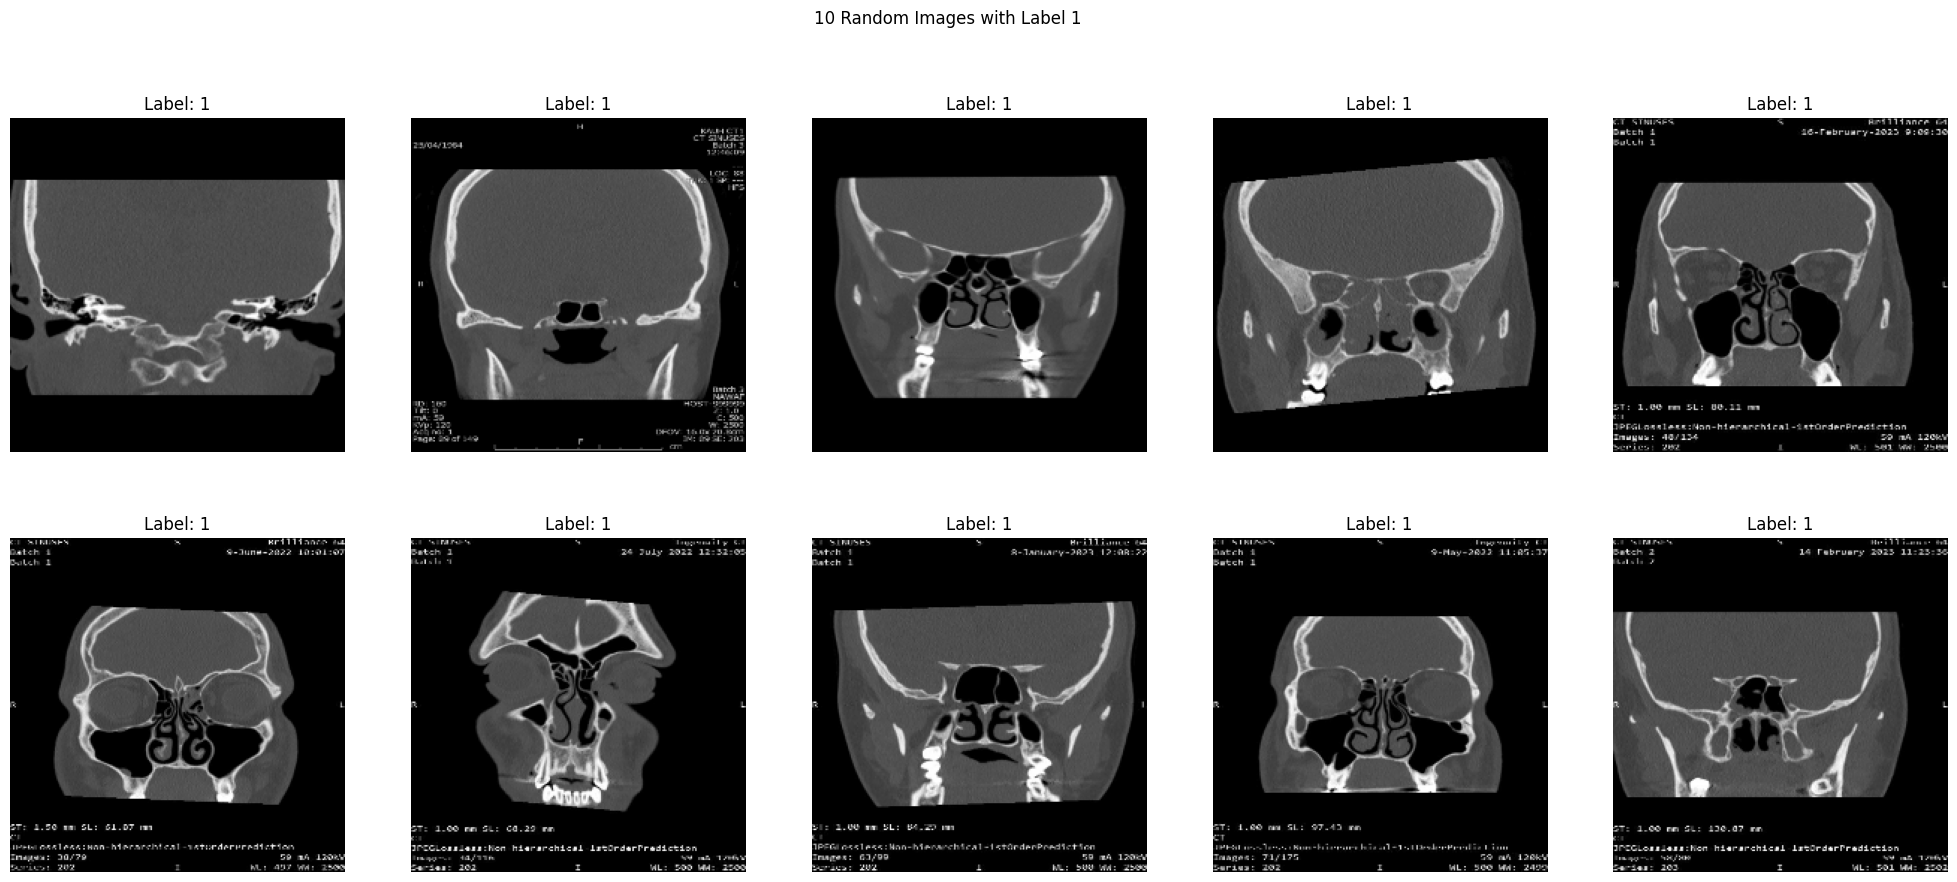

In [13]:
import matplotlib.pyplot as plt
import random

# Helper function to plot images
def plot_images(images, labels, title, num_images=10, images_per_row=5):
    num_rows = (num_images + images_per_row - 1) // images_per_row  # Calculate the number of rows needed
    plt.figure(figsize=(images_per_row * 5, num_rows * 5))
    for i in range(num_images):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Collect random 10 images with label 0 and 10 images with label 1
zeros_images = [img for img, label in zip(X_train, y_train) if label == 0]
ones_images = [img for img, label in zip(X_train, y_train) if label == 1]

# Shuffle and select 10 random images for each label
random.shuffle(zeros_images)
random.shuffle(ones_images)

zeros_images = zeros_images[:10]
ones_images = ones_images[:10]

# Plot the images
plot_images(zeros_images, [0] * 10, "10 Random Images with Label 0")
plot_images(ones_images, [1] * 10, "10 Random Images with Label 1")


In [8]:
from tensorflow.keras.callbacks import EarlyStopping
# Load VGG16 as the base model, without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
from tensorflow.keras.callbacks import ModelCheckpoint
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
# Define the directory to save the model
save_dir = "C:/Users/USER/Desktop/GP2 last/20-5"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "VGG16_model.h5")

# Add custom layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=45,
    verbose=1,
    callbacks=[early_stop,checkpoint]  # Include the EarlyStopping callback here
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

Epoch 1/20
300/300 [==============================] - ETA: 0s - loss: 1.4893 - accuracy: 0.8223
Epoch 1: val_accuracy improved from -inf to 0.80759, saving model to C:/Users/USER/Desktop/GP2 last/20-5\VGG16_model.h5
300/300 [==============================] - 22s 73ms/step - loss: 1.4893 - accuracy: 0.8223 - val_loss: 0.5240 - val_accuracy: 0.8076
Epoch 2/20
299/300 [============================>.] - ETA: 0s - loss: 0.1992 - accuracy: 0.9145
Epoch 2: val_accuracy did not improve from 0.80759
300/300 [==============================] - 21s 69ms/step - loss: 0.1994 - accuracy: 0.9144 - val_loss: 0.8068 - val_accuracy: 0.7380
Epoch 3/20
299/300 [============================>.] - ETA: 0s - loss: 0.1438 - accuracy: 0.9359
Epoch 3: val_accuracy did not improve from 0.80759
300/300 [==============================] - 20s 68ms/step - loss: 0.1441 - accuracy: 0.9359 - val_loss: 0.8025 - val_accuracy: 0.7994
Epoch 4/20
299/300 [============================>.] - ETA: 0s - loss: 0.1117 - accuracy: 0.

# visualization

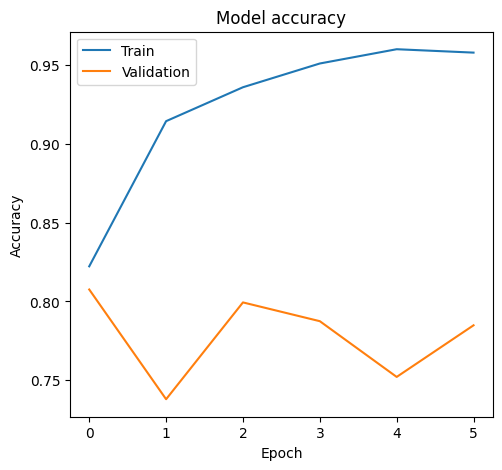

In [18]:
import matplotlib.pyplot as plt

# Function to plot the training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
   

# Call the function to plot the training history
plot_training_history(history)


84/84 [==============================] - 3s 37ms/step
ROC AUC Score: 0.8345962844290604


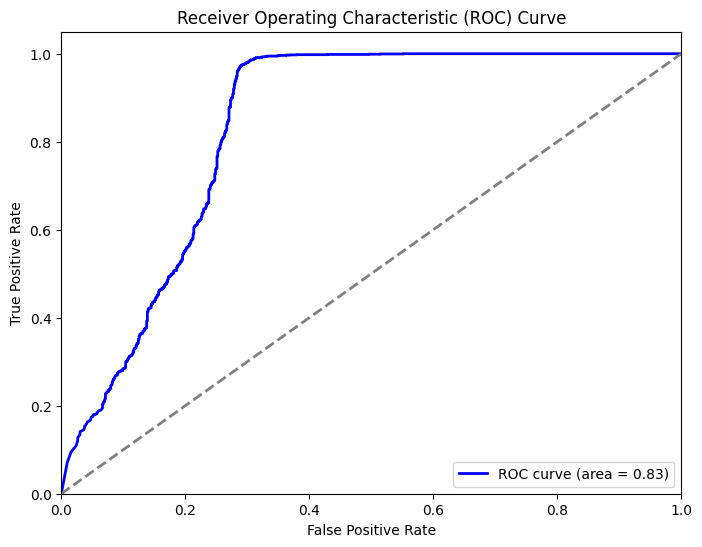

In [22]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = model.predict(X_test).ravel()  # model.predict returns probabilities for class 1

# Convert probabilities to binary predictions
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")


# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Confusion Matrix:
[[ 613  215]
 [ 363 1496]]


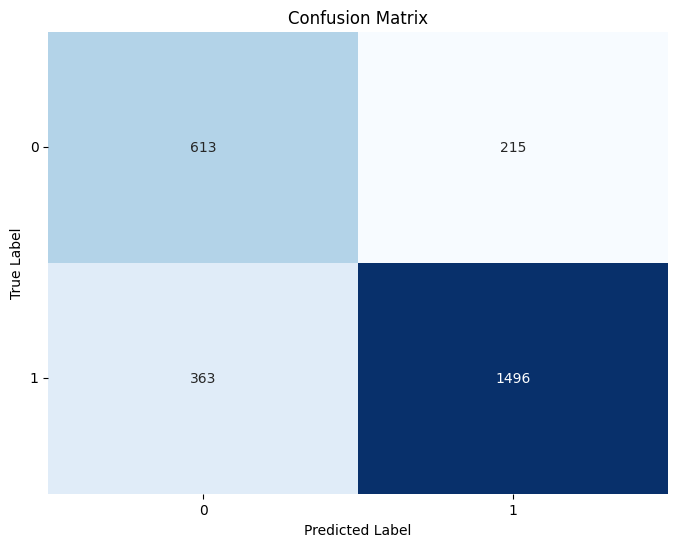

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
#!pip install seaborn 

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5], ['0', '1'])  # Setting tick marks for predicted labels
plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)  # Setting tick marks for true labels
plt.show()


84/84 [==============================] - 3s 37ms/step


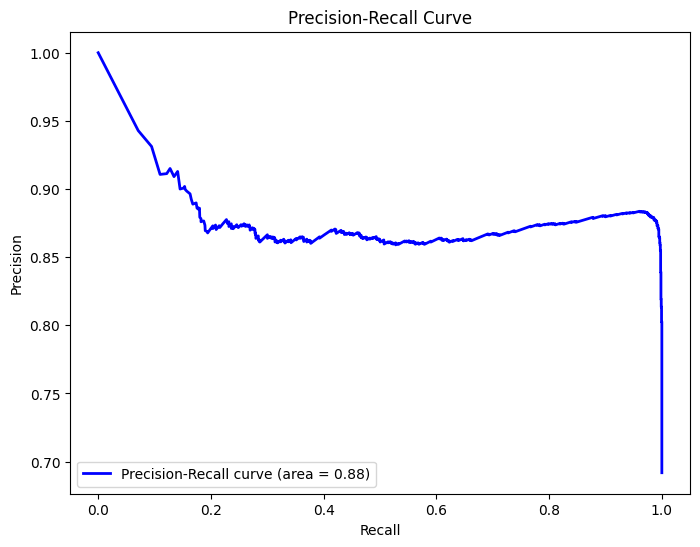

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision
y_scores = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()



# Evaluation

In [14]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix



y_pred_proba = model.predict(X_test).ravel()  # model.predict returns probabilities for class 1

# Convert probabilities to binary predictions
y_pred = (y_pred_proba > 0.5).astype(int)

#Calculate ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

#Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

#Calculate Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

#Calculate Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")


84/84 [==============================] - 3s 40ms/step
ROC AUC Score: 0.8345962844290604
F1 Score: 0.8380952380952381
Recall: 0.8047337278106509
Precision: 0.8743424897720631


In [15]:

# Generate and print Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 613  215]
 [ 363 1496]]


# TESTING

In [40]:
#!pip install openpyxl
from tensorflow.keras.models import load_model
model_path = "C:/Users/USER/Desktop/LAST GP CTSCAN 21-5/VGG16_model.h5"
model = load_model(model_path)
test_data_path = "C:/Users/USER/Desktop/GP2 last/16-5/14-5/CSV/test.xlsx"
#test_data_path = "C:/Users/ACER/Desktop/GP2/last/GP2/CSV_DATASETS/test.xlsx"
test_df = pd.read_excel(test_data_path)

def load_and_preprocess_images(patient_id, base_path):
    images = []
    images_path = os.path.join(base_path, patient_id, "Images") if "Images" in os.listdir(os.path.join(base_path, patient_id)) else os.path.join(base_path, patient_id)
    
    if os.path.isdir(images_path):
        image_files = [f for f in os.listdir(images_path) if is_image_file(f)]
        image_files = sorted(image_files)
        image_files = image_files[10:-10] 
        for filename in image_files:
            file_path = os.path.join(images_path, filename)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                img = np.stack((img,)*3, axis=-1)  # Convert grayscale to RGB
                images.append(img)

    return np.array(images)
    
def predict_patient_outcome(patient_id, model, base_path):
    images = load_and_preprocess_images(patient_id, base_path)
    if len(images) == 0:
        print(f"No images found for patient {patient_id}")
        return {'decision': None, 'count_0': 0, 'count_1': 0}

    predictions = model.predict(images)
    predicted_labels = (predictions >0.5).astype(int)  

    # Count how many 0s and 1s
    count_0 = np.sum(predicted_labels == 0)
    count_1 = np.sum(predicted_labels == 1)

   
    #mean_prediction = np.mean(predictions)
    decision = 1 if count_1 > count_0 else 0

    return {'decision': decision, 'count_0': count_0, 'count_1': count_1}


#base_path = "D:/GP2/dataset/CASES"
#base_path = "C:/Users/USER/Desktop/gp2 ct scan/our all cases/CASES"
base_path = "C:/Users/USER/Desktop/DATASET CT/TEST"
# Iterate over each patient ID in the test data
results = {}
for _, row in test_df.iterrows():
    patient_id = row['id']
    outcome = predict_patient_outcome(patient_id, model, base_path)
    results[patient_id] = outcome

print(results)


3/3 [==============================] - 0s 36ms/step
{'KA00564333': {'decision': 1, 'count_0': 1, 'count_1': 79}, 'KA00690958': {'decision': 1, 'count_0': 30, 'count_1': 46}, 'KA00671484': {'decision': 0, 'count_0': 62, 'count_1': 11}}
